In [2]:
import tensorflow as tf
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import optimizers


from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
 
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [3]:
ref = pd.read_csv("E:\Important\Code\MinorProject\Data_path.csv")
ref.head()

,labels,source,path
0,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...
1,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...
2,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...
3,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...
4,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...


In [4]:
df = pd.DataFrame(columns=['feature'])

# feature extraction over entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   



print(len(df))
df.head()

12162


,feature
0,"[-4.6414213, -3.860898, -6.21919, -5.9265423, ..."
1,"[-8.690716, -12.522837, -22.928043, -23.243807..."
2,"[-8.814859, -12.819055, -24.178183, -23.84745,..."
3,"[-2.2684252, -4.317077, -12.285238, -13.083024..."
4,"[-13.485307, -16.26042, -25.884357, -27.827044..."


# Data Processing

In [5]:
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...,-4.641421,-3.860898,-6.219190,-5.926542,-5.850419,-4.808960,-2.513003,...,-4.088852,-5.023864,-5.254714,-5.234095,-5.310307,-5.621666,-6.072197,-6.611348,-3.999875,1.390506
1,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...,-8.690716,-12.522837,-22.928043,-23.243807,-22.926605,-23.432241,-14.830004,...,-22.627258,-22.633406,-22.511597,-24.300154,-24.496809,-22.895985,-23.511503,-24.342152,-16.465857,-8.936035
2,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...,-8.814859,-12.819055,-24.178183,-23.847450,-15.182783,-10.732485,-8.681472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...,-2.268425,-4.317077,-12.285238,-13.083024,-12.041327,-11.819768,-9.414148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...,-13.485307,-16.260420,-25.884357,-27.827044,-27.593534,-26.666508,-18.659023,...,-25.291666,-25.854906,-26.821354,-25.436455,-24.179941,-23.281618,-24.167494,-25.228062,-20.599659,-15.929615


In [6]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...,-4.641421,-3.860898,-6.219190,-5.926542,-5.850419,-4.808960,-2.513003,...,-4.088852,-5.023864,-5.254714,-5.234095,-5.310307,-5.621666,-6.072197,-6.611348,-3.999875,1.390506
1,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...,-8.690716,-12.522837,-22.928043,-23.243807,-22.926605,-23.432241,-14.830004,...,-22.627258,-22.633406,-22.511597,-24.300154,-24.496809,-22.895985,-23.511503,-24.342152,-16.465857,-8.936035
2,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...,-8.814859,-12.819055,-24.178183,-23.847450,-15.182783,-10.732485,-8.681472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...,-2.268425,-4.317077,-12.285238,-13.083024,-12.041327,-11.819768,-9.414148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_angry,SAVEE,E:\Important\Code\MinorProject\final datasets\...,-13.485307,-16.260420,-25.884357,-27.827044,-27.593534,-26.666508,-18.659023,...,-25.291666,-25.854906,-26.821354,-25.436455,-24.179941,-23.281618,-24.167494,-25.228062,-20.599659,-15.929615


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )


X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,-17.142696,-17.249537,-18.365582,-18.948351,-17.365459,-16.711090,-17.699480,-18.021383,-17.897398,-15.878503,...,-22.865425,-21.614164,-19.724932,-18.845335,-19.363422,-20.137630,-22.65514,-24.578310,-24.039165,-23.209587
3860,-13.285580,-16.784796,-23.058235,-22.435648,-20.332132,-19.029636,-19.715996,-13.186263,-11.762837,-16.709417,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
9761,-4.823564,-6.056048,-9.580621,-12.012061,-9.959866,-11.912548,-13.994515,-13.555813,-14.022305,-15.118245,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7620,-7.031146,-4.253551,-4.534490,-5.836689,-5.248197,-6.456453,-8.122451,-9.154640,-8.647813,-8.178625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
11586,-22.565975,-21.767015,-20.529488,-20.669310,-21.171085,-18.573399,-18.412350,-16.178038,-14.222460,-15.122539,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7914,-20.082027,-18.982424,-17.009443,-16.944057,-19.334974,-19.527683,-21.974346,-20.144060,-17.954927,-19.302570,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
9513,-20.103537,-18.625866,-16.116106,-16.929594,-18.197668,-18.149664,-19.240425,-18.361637,-16.917982,-16.639193,...,-17.848896,-19.357054,-17.748692,-19.136808,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5835,-21.078182,-18.671947,-17.676802,-18.009502,-18.218781,-18.676929,-16.592762,-17.796528,-17.992470,-17.824917,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5389,-22.707441,-20.160748,-18.926155,-19.429979,-19.278114,-18.125767,-18.068565,-19.879322,-20.896751,-19.176098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
11222,-20.008287,-17.640305,-19.188616,-18.435749,-17.538836,-17.817177,-17.898472,-20.555359,-18.578117,-15.957151,...,-18.031603,-18.101122,-19.630695,-20.707493,-20.239124,-18.337662,-15.54331,-17.478794,-17.017057,-19.112486


In [19]:
# doing normalization because it helps models to learn fast
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


X_train[150:160]


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,0.372040,0.350815,0.438080,0.388334,0.499361,0.543761,0.462610,0.433154,0.435841,0.580895,...,-0.881535,-0.813732,-0.693296,-0.631321,-0.678039,-0.721057,-0.863782,-0.987440,-0.973409,-0.919264
3860,0.649921,0.385113,0.089816,0.130061,0.279967,0.372251,0.313701,0.789557,0.887543,0.519734,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
9761,1.259557,1.176896,1.090053,0.902044,1.047028,0.898725,0.736201,0.762317,0.721173,0.636856,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
7620,1.100515,1.309921,1.464550,1.359398,1.395471,1.302330,1.169821,1.086733,1.116910,1.147660,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
11586,-0.018674,0.017424,0.277486,0.260878,0.217923,0.406000,0.409968,0.569030,0.706435,0.636540,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
7914,0.160279,0.222927,0.538725,0.536774,0.353709,0.335408,0.146934,0.276689,0.431605,0.328860,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
9513,0.158729,0.249241,0.605024,0.537846,0.437817,0.437345,0.348819,0.408074,0.507957,0.524903,...,-0.569656,-0.673821,-0.571176,-0.649229,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
5835,0.088512,0.245841,0.489197,0.457866,0.436256,0.398342,0.544335,0.449729,0.428840,0.437626,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
5389,-0.028866,0.135967,0.396477,0.352664,0.357914,0.439113,0.435355,0.296204,0.214991,0.338169,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
11222,0.165591,0.321976,0.376998,0.426298,0.486540,0.461940,0.447915,0.246372,0.385718,0.575106,...,-0.581015,-0.595970,-0.687473,-0.745729,-0.731844,-0.610848,-0.431651,-0.557426,-0.544537,-0.670812


In [20]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encoding
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [21]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

In [ ]:
# Baseline model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))

model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))

model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))

model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          2304      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 256)          524544    
                                                                 
 batch_normalization (BatchN  (None, 216, 256)         1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 216, 256)          0         
                                                                 
 dropout (Dropout)           (None, 216, 256)          0         
                                                        

In [ ]:
opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00001, decay=1e-6)#lr=0.00001, decay=1e-6
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### training

In [ ]:
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

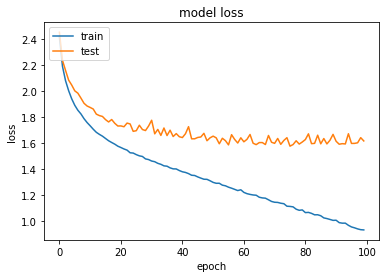

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

96/96 [==============================] - 7s 78ms/step - loss: 1.6156 - accuracy: 0.4341


[1.615605115890503, 0.4340677261352539]

## MODEL SAVING


In [ ]:
model_name = 'emotion_model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models') 

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s' % model_path)

model_json = model.to_json()
with open('model_json.json', 'w') as json_file:
    json_file.write(model_json)

Save model and weights at e:\Important\Code\MinorProject\saved_models\emotion_model.h5


## Model Validation


In [26]:
# loading json and model architecture
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# loading weights into new model
loaded_model.load_weights('saved_models/emotion_model.h5')
print('Model is loaded from disk')

# keras optimiser
opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose = 0)
print('%s: %.2f%%' % (loaded_model.metrics_names[1], score[1]*100))

Model is loaded from disk
accuracy: 43.41%


In [28]:
predicted = loaded_model.predict(X_test, batch_size = 16, verbose = 1)
predicted = predicted.argmax(axis = 1)
predicted

191/191 [==============================] - 12s 58ms/step


array([4, 3, 7, ..., 0, 4, 4], dtype=int64)

In [29]:
len(predicted)

3041

In [30]:
# predicted labels
predicted = predicted.astype(int).flatten()
predicted = (lb.inverse_transform(predicted))
predicted = pd.DataFrame({'predictedvalues': predicted})

# Actual Labels
actual = y_test.argmax(axis=1)  # returns indices of maximum value
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform(actual))
actual = pd.DataFrame({'actualvalues': actual})

final_df = actual.join(predicted)
final_df[170:180]

,actualvalues,predictedvalues
170,male_sad,male_sad
171,female_neutral,female_neutral
172,male_angry,male_happy
173,female_disgust,female_disgust
174,male_angry,male_angry
175,female_fear,female_fear
176,male_neutral,male_neutral
177,female_fear,female_disgust
178,female_happy,male_happy
179,female_neutral,female_neutral


In [31]:
final_df.to_csv('Predictions.csv', index = False)
final_df.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,379
female_disgust,282
female_fear,242
female_happy,275
female_neutral,534
female_sad,273
female_surprise,108
male_angry,145
male_disgust,72


Confusion Matrices :

In [32]:
def print_confusion_matrix(confusion_matrix, class_name, figsize=(10,7), fontsize = 14):

    df_cm = pd.DataFrame(confusion_matrix, index = class_name, columns = class_name)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

###### Emotion by gender accuracy


0.4340677408747123


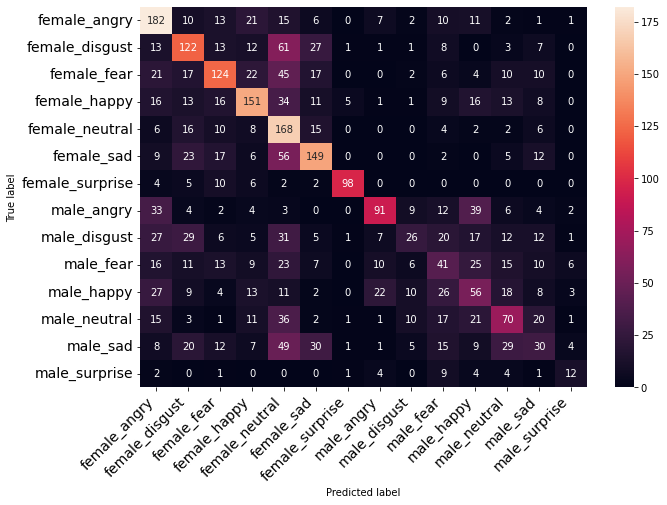

In [33]:
final_df = pd.read_csv('Predictions.csv')
classes = final_df.actualvalues.unique()
classes.sort()

#confusion matrix
c = confusion_matrix(final_df.actualvalues, final_df.predictedvalues)
print(accuracy_score(final_df.actualvalues, final_df.predictedvalues))
print_confusion_matrix(c, classes)

In [34]:
classes = final_df.actualvalues.unique()
classes.sort()
print(classification_report(final_df.actualvalues, final_df.predictedvalues, target_names = classes))

                 precision    recall  f1-score   support

   female_angry       0.48      0.65      0.55       281
 female_disgust       0.43      0.45      0.44       269
    female_fear       0.51      0.45      0.48       278
   female_happy       0.55      0.51      0.53       294
 female_neutral       0.31      0.71      0.44       237
     female_sad       0.55      0.53      0.54       279
female_surprise       0.91      0.77      0.83       127
     male_angry       0.63      0.44      0.51       209
   male_disgust       0.36      0.13      0.19       199
      male_fear       0.23      0.21      0.22       192
     male_happy       0.27      0.27      0.27       209
   male_neutral       0.37      0.33      0.35       209
       male_sad       0.23      0.14      0.17       220
  male_surprise       0.40      0.32      0.35        38

       accuracy                           0.43      3041
      macro avg       0.45      0.42      0.42      3041
   weighted avg       0.44   

###### Gender Accuracy result

0.7823084511673791


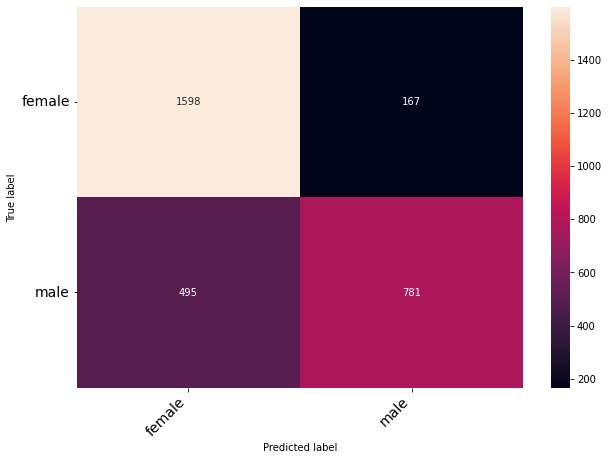

In [35]:
modidf = final_df
modidf['actualvalues'] = final_df.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = final_df.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_name = classes)

In [36]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.76      0.91      0.83      1765
        male       0.82      0.61      0.70      1276

    accuracy                           0.78      3041
   macro avg       0.79      0.76      0.77      3041
weighted avg       0.79      0.78      0.78      3041



###### Emotion accuracy

0.4995067412035515


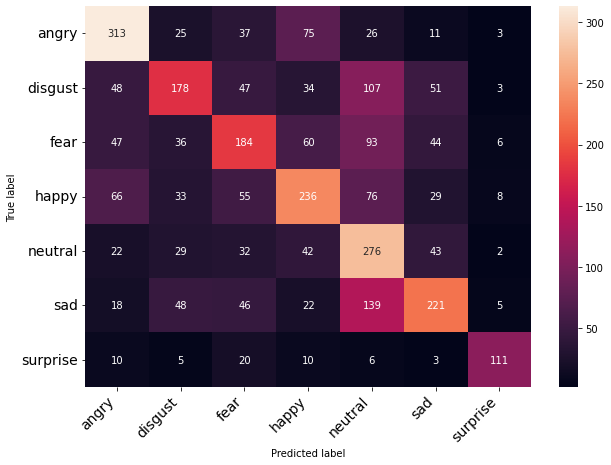

In [37]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_name = classes)

In [38]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.60      0.64      0.62       490
     disgust       0.50      0.38      0.43       468
        fear       0.44      0.39      0.41       470
       happy       0.49      0.47      0.48       503
     neutral       0.38      0.62      0.47       446
         sad       0.55      0.44      0.49       499
    surprise       0.80      0.67      0.73       165

    accuracy                           0.50      3041
   macro avg       0.54      0.52      0.52      3041
weighted avg       0.51      0.50      0.50      3041

